# Augmented Distillation - Binary Classification
In this example, we will use the [Adult Census Income](https://www.kaggle.com/uciml/adult-census-income). 
based on the paper

## Setup

In [57]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../.')
sys.path.append('../conformal_pred')

## EDA

In [58]:
csv_path = Path(r"C:\Users\orrav\Documents\Datasets\Adult Census Income\adult.csv")

df = pd.read_csv(csv_path)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Set ? to NaNs

In [60]:
df[df == '?'] = np.nan

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Fill-out missing values
We can see that `workclass`, `occupation` and `native.country` have missing values. These features are categorical and we can therefore fill them out with `mode`.



In [62]:
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [64]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

### Setting features and target variables

In [65]:
X = df.drop(['income'], axis=1)

y = df['income'].map({'<=50K': 0, '>50K': 1})

### Test splitting

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [67]:
pX_train, pX_test = X_train.copy(), X_test.copy()

### Feature engineering

We'll be using `LabelEncoder` to encode categorical text features into integers. We also a standard normalization of the tabular features in the form of centering and std scaling.

In [68]:
from sklearn import preprocessing

categorical = X.select_dtypes(include=["object"]).columns
label_encoders = []
for feature in categorical:
        label_enc = preprocessing.LabelEncoder()
        pX_train.loc[:, feature] = label_enc.fit_transform(X_train[feature])
        pX_test.loc[:, feature] = label_enc.transform(X_test[feature])
        label_encoders.append(label_enc)

In [69]:
pX_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
7872,64,3,321166,9,13,0,11,1,4,0,0,0,5,38
31180,31,1,94991,11,9,0,7,4,0,1,0,0,40,38
25875,25,3,44363,11,9,4,5,1,4,1,0,0,35,38
4345,37,3,254202,9,13,2,11,0,4,1,0,0,50,38
15278,63,3,237620,11,9,2,2,0,4,1,0,0,30,38


In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pX_train = pd.DataFrame(scaler.fit_transform(pX_train), columns=X.columns)
pX_test = pd.DataFrame(scaler.transform(pX_test), columns=X.columns)

In [71]:
pX_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.850713,-0.088376,1.246786,-0.332697,1.135385,-1.742386,1.236648,-0.276827,0.393160,-1.434521,-0.14426,-0.217063,-2.885649,0.260859
1,-0.560269,-1.889076,-0.891714,0.185015,-0.421692,-1.742386,0.230318,1.590090,-4.327948,0.697097,-0.14426,-0.217063,-0.042075,0.260859
2,-0.998630,-0.088376,-1.370405,0.185015,-0.421692,0.921843,-0.272846,-0.276827,0.393160,0.697097,-0.14426,-0.217063,-0.448300,0.260859
3,-0.121909,-0.088376,0.613637,-0.332697,1.135385,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859
4,1.777653,-0.088376,0.456853,0.185015,-0.421692,-0.410272,-1.027593,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.854525,0.260859


In [72]:
pX_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

As seen by the plot below, the two classes (smaller or larger than a 50k income) are slightly imbalanced. Therefore, we chose a *macro-F1* as our measure of success for this task.

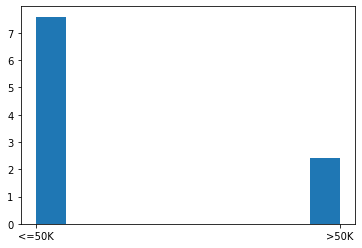

In [73]:
plt.hist(df['income'], density=True)
plt.show()

## Fit Student

First, let's fit a **Random Forest** classifier as our student model. We set `n_estimators` as default of 100 estimators.

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score

In [130]:
clf = RandomForestClassifier(random_state=0)
clf.fit(pX_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [131]:
test_preds = clf.predict(pX_test)
test_probas = clf.predict_proba(pX_test)[:, 1]

### Metrics
Macro-F1 and ROC-AUC

In [132]:
f1_score(y_test, test_preds, average='macro')

0.7763204980174745

In [133]:
roc_auc_score(y_test, test_probas)

0.8803877171628337

## Fit Teacher (AutoGluon)

For the teacher model, we'll be using [AutoGluon](https://auto.gluon.ai/stable/index.html), which is an intuitive AutoML framework for multiple applications, including tabular data.

In [79]:
import graphviz
from autogluon.tabular import TabularDataset, TabularPredictor

In [80]:
label = 'income'
df_train = pX_train.copy()
df_train[label] = y_train.reset_index(drop=True)
df_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,1.850713,-0.088376,1.246786,-0.332697,1.135385,-1.742386,1.236648,-0.276827,0.393160,-1.434521,-0.14426,-0.217063,-2.885649,0.260859,0
1,-0.560269,-1.889076,-0.891714,0.185015,-0.421692,-1.742386,0.230318,1.590090,-4.327948,0.697097,-0.14426,-0.217063,-0.042075,0.260859,0
2,-0.998630,-0.088376,-1.370405,0.185015,-0.421692,0.921843,-0.272846,-0.276827,0.393160,0.697097,-0.14426,-0.217063,-0.448300,0.260859,0
3,-0.121909,-0.088376,0.613637,-0.332697,1.135385,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859,0
4,1.777653,-0.088376,0.456853,0.185015,-0.421692,-0.410272,-1.027593,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.854525,0.260859,0


In [81]:
df_test = pX_test.copy()
df_test[label] = y_test.reset_index(drop=True)
df_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,1.266233,-0.088376,0.805319,-1.109266,-1.978770,2.253958,1.236648,1.590090,0.393160,-1.434521,-0.14426,-0.217063,-0.042075,0.260859,0
1,-1.436990,-0.088376,0.455293,0.185015,-0.421692,0.921843,-0.272846,0.967785,0.393160,-1.434521,-0.14426,-0.217063,-1.260750,0.260859,0
2,-1.144750,-0.088376,-0.603334,1.220441,-0.032423,0.921843,0.230318,-0.276827,-3.147671,-1.434521,-0.14426,-0.217063,-0.448300,0.426445,0
3,-0.121909,-2.789426,-1.328652,-0.332697,1.135385,-0.410272,0.733483,-0.899132,0.393160,0.697097,-0.14426,-0.217063,-0.042075,0.260859,0
4,0.754812,-0.088376,2.211732,0.443872,1.524654,-0.410272,1.236648,-0.899132,0.393160,0.697097,-0.14426,-0.217063,0.770375,0.260859,1


In [82]:
time_limit = 60 #600  # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'roc_auc'  # specify your evaluation metric here
predictor = TabularPredictor(label, eval_metric=metric).fit(df_train, time_limit=time_limit, presets='best_quality', auto_stack=True)
predictor.leaderboard(df_test, silent=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20210730_155720\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20210730_155720\"
AutoGluon Version:  0.2.0
Train Data Rows:    16280
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1869.96 MB
	Train Data (Original)  Memory Usage: 1.82 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set fea

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,0.925207,0.927467,1.537489,0.163111,10.947998,1.537489,0.163111,10.947998,1,True,4
1,WeightedEnsemble_L2,0.925146,0.927497,5.304272,0.417144,32.150817,0.002980,0.010750,5.423914,2,True,7
2,LightGBMXT_BAG_L1,0.920920,0.922332,3.763802,0.243284,15.778904,3.763802,0.243284,15.778904,1,True,3
3,RandomForestGini_BAG_L1,0.905043,0.906127,0.742732,1.143760,3.351166,0.742732,1.143760,3.351166,1,True,5
4,RandomForestEntr_BAG_L1,0.900699,0.891174,0.165106,0.095909,0.415925,0.165106,0.095909,0.415925,1,True,6
5,KNeighborsDist_BAG_L2,0.859941,0.879682,25.159370,18.374970,31.315113,12.852915,12.569416,0.010000,2,True,9
6,WeightedEnsemble_L3,0.859941,0.879682,25.160396,18.384741,33.163088,0.001026,0.009771,1.847975,3,True,10
7,KNeighborsUnif_BAG_L2,0.858357,0.873132,23.002962,17.630120,31.325801,10.696508,11.824566,0.020688,2,True,8
8,KNeighborsDist_BAG_L1,0.846997,0.845932,2.898055,2.062418,0.411388,2.898055,2.062418,0.411388,1,True,2
9,KNeighborsUnif_BAG_L1,0.846808,0.846039,3.199270,2.097073,0.399731,3.199270,2.097073,0.399731,1,True,1


## Augment training samples for distillation

Training the student on an augmeneted training set, should reduce the approximation error between the teacher and the student, and should therefore lead to better results at the same computational cost. The augmentation procedure is composed of two main stages:
1. For all features $i$, estimate the conditional distribution $p(x^i | x^{-i})$ using the training data.
2. Sample new features

The conditional ditribution estimation is done via a Self-Attention mechanism trained with a pseudolikelihood objective. When sampling, we compare between two methods. The first method, and the one presented in the paper is Gibbs sampling, which aims to estimate $p(x)$ directly. The second method, is simply by using the output of the Self-Attention model, which estimated the conditioal distribution of each feature.

In [83]:
import torch
from torch.utils.data import DataLoader
from models.transformer import CondEncoder

In [84]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_obj):

        # data size
        self.N = data_obj.shape[0]
        self.data = data_obj.astype(np.float32)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x

    def __len__(self):
        return self.N

In [85]:
ds_train = Dataset(data_obj=pX_train.to_numpy())
train_loader = DataLoader(ds_train, batch_size=100, shuffle=True)

In [171]:
import time
n_feat = [1, 5, 10, 15, 20, 100, 300, 500]
# n_feat = [2, 14, 500]
# durs = []
# for feat in n_feat:
#     x = np.random.random((1000, feat))
#     ds = Dataset(data_obj=x)
#     loader = DataLoader(ds, batch_size=1)
#     start = time.time()
#     enc.sample_conditionals(train_loader, num_iter=1)
#     dur = time.time() - start
#     durs.append(dur)

In [166]:
gibbs_durs = durs

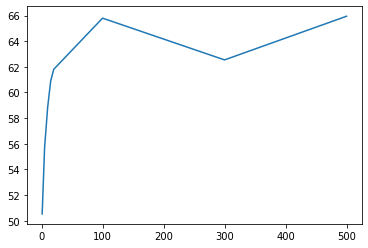

In [167]:
plt.plot(n_feat, gibbs_durs)

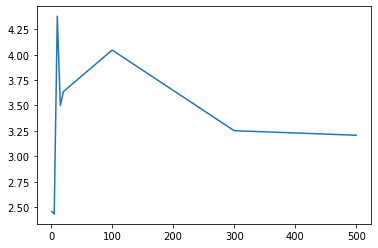

In [164]:
plt.plot(n_feat, cond_durs)

Text(0.5, 1.0, 'Sampling time [sec] per 1k samples')

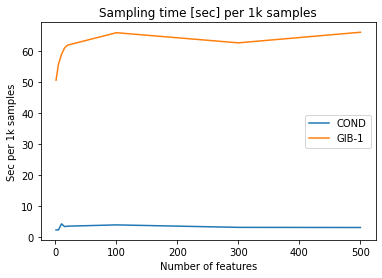

In [179]:
plt.plot(n_feat, cond_durs, n_feat, gibbs_durs)
plt.xlabel("Number of features")
plt.ylabel("Sec per 1k samples")
plt.legend(["COND", "GIB-1"])
plt.title("Sampling time [sec] per 1k samples")

### Training the PL conditionals estimator
`CondEncoder` represents the self-attention-based encoder and is trained by minimized the negative log-likelihood of the conditionals. Each conditional is paramterized as a mixture of Gaussians.

In [86]:
#cond_enc = CondEncoder(epochs=2000)

In [87]:
#cond_enc.fit(train_loader)

In [88]:
model_path = Path(r"C:\Users\orrav\Documents\Github\augmented-distillation\ck\adults_income\adults_income_features.pt")
cond_enc = torch.load(model_path)

### Sampling

In [89]:
def inverse_transform_samples(df, scaler, categorical_features, label_encoders):
    aug_samples_df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns).astype(np.int64)
    # clip negative values
    aug_samples_df[aug_samples_df < 0] = 0
    for j, feature in enumerate(categorical_features):
        # clip out-of-category values
        len_cls = len(list(label_encoders[j].classes_))
        aug_samples_df.loc[aug_samples_df[feature] >= len_cls, feature] = len_cls - 1
        aug_samples_df.loc[:, feature] = label_encoders[j].inverse_transform(aug_samples_df[feature])
    return aug_samples_df

def transform_samples(df, categorical_features, label_encoders):
    dff = df.copy()
    # encode object features to categorical integers
    for j, feature in enumerate(categorical_features):
        dff.loc[:, feature] = label_encoders[j].transform(dff[feature])
    # fit a new scaler
    scaler = StandardScaler()
    aug_samples_df = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
    return aug_samples_df

#### Gibbs sampling
A practical challenge of the Gibbs sampler is that it's sensitive to initialization. Here, we initialize the sampler with original samples from the training set. Notice that `num_iter` should be multiplied by the size of the original training set. Meaning, `num_iter=5` and `len(pX_train)=1000` will generate 5k samples that can be used for distillation. In addition, one-round of Gibbs sampling is examined, based on the paper's results.

In [90]:
aug_samples = cond_enc.sample_gibbs(train_loader, rounds=1, num_iter=5)

In [91]:
aug_samples_df = pd.DataFrame(aug_samples, columns=X.columns)
gibbs_df = inverse_transform_samples(aug_samples_df, scaler, categorical, label_encoders)
gibbs_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,32,Private,184799,Assoc-voc,10,Divorced,Prof-specialty,Not-in-family,Other,Female,36,0,15,United-States
1,70,Never-worked,346833,Doctorate,8,Married-civ-spouse,Machine-op-inspct,Unmarried,Other,Male,2,1,40,United-States
2,51,Private,207694,HS-grad,8,Married-AF-spouse,Craft-repair,Husband,Black,Male,0,0,43,Trinadad&Tobago
3,35,Federal-gov,179927,Prof-school,10,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,6026,0,40,United-States
4,54,Self-emp-inc,89845,Doctorate,8,Married-civ-spouse,Craft-repair,Husband,Other,Male,0,0,40,United-States


#### Conditionals sampling

In [92]:
aug_cond_samples = cond_enc.sample_conditionals(train_loader, num_iter=5)

In [93]:
aug_cond_samples_df = pd.DataFrame(aug_cond_samples, columns=X.columns)
cond_df = inverse_transform_samples(aug_cond_samples_df, scaler, categorical, label_encoders)
cond_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,19,Local-gov,174713,Prof-school,9,Never-married,Prof-specialty,Other-relative,Other,Female,0,0,15,United-States
1,43,Self-emp-not-inc,54310,HS-grad,14,Married-AF-spouse,Prof-specialty,Husband,Other,Female,7298,0,40,United-States
2,28,Private,111900,9th,12,Married-AF-spouse,Protective-serv,Husband,Other,Female,0,0,29,United-States
3,19,Private,435469,HS-grad,9,Never-married,Other-service,Other-relative,Other,Female,0,0,40,Laos
4,69,Self-emp-not-inc,237065,5th-6th,3,Separated,Other-service,Other-relative,Other,Female,2345,0,40,United-States


### Augmented Distillation

First, process the sampled data for distillation in a similar manner to the pre-processing of the original training set. Then, Predict labels by the teacher model. The assumption here is that the teacher's accuracy is very high so we can actually count on it for labeling.

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
def predict_soft_labels(df, categorical, label_encoders, teacher):
    dff = transform_samples(df, categorical, label_encoders)
    teacher_preds = teacher.predict_proba(dff)
    teacher_preds_np = teacher_preds.iloc[:, 1].to_numpy()
    df_aug_teacher_preds = dff.copy()
    df_aug_teacher_preds[label] = teacher_preds_np
    return df_aug_teacher_preds

#### Distillation via Gibbs-sampled augmented data

In [96]:
df_aug_gibbs_teacher_preds = predict_soft_labels(gibbs_df, categorical, label_encoders, predictor)
df_aug_gibbs_teacher_preds.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-0.437442,0.556509,-0.067242,-0.410466,0.141709,-1.838100,0.953974,-0.046485,-0.375137,-1.169203,-0.176497,-0.194480,-2.075017,0.330755,0.019015
1,2.226304,-0.361662,1.473895,0.123984,-0.644573,-0.173449,0.146807,2.426622,-0.375137,0.855283,-0.185716,-0.190975,0.024792,0.330755,0.101407
2,0.894431,0.556509,0.150517,0.391208,-0.644573,-1.005774,-0.929415,-0.870853,-1.461214,0.855283,-0.186258,-0.194480,0.276769,0.131165,0.272525
3,-0.227146,-2.198004,-0.113580,1.192882,0.141709,-0.173449,-0.929415,-0.870853,-2.547291,0.855283,1.447631,-0.194480,0.024792,0.330755,0.996745
4,1.104727,1.474680,-0.970368,0.123984,-0.644573,-0.173449,-0.929415,-0.870853,-0.375137,0.855283,-0.186258,-0.194480,0.024792,0.330755,0.227535


Concatenate the original training set and the augmented samples after being labeled by the teacher model. This forms the new training set for fitting the student model.

In [97]:
print(f"Original training set size: {len(df_train)}\nAugmeneted training set size: {len(df_aug_gibbs_teacher_preds)}")
df_aug = pd.concat([df_aug_gibbs_teacher_preds, df_train])
df_aug.head()

Original training set size: 16280
Augmeneted training set size: 81400


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-0.437442,0.556509,-0.067242,-0.410466,0.141709,-1.838100,0.953974,-0.046485,-0.375137,-1.169203,-0.176497,-0.194480,-2.075017,0.330755,0.019015
1,2.226304,-0.361662,1.473895,0.123984,-0.644573,-0.173449,0.146807,2.426622,-0.375137,0.855283,-0.185716,-0.190975,0.024792,0.330755,0.101407
2,0.894431,0.556509,0.150517,0.391208,-0.644573,-1.005774,-0.929415,-0.870853,-1.461214,0.855283,-0.186258,-0.194480,0.276769,0.131165,0.272525
3,-0.227146,-2.198004,-0.113580,1.192882,0.141709,-0.173449,-0.929415,-0.870853,-2.547291,0.855283,1.447631,-0.194480,0.024792,0.330755,0.996745
4,1.104727,1.474680,-0.970368,0.123984,-0.644573,-0.173449,-0.929415,-0.870853,-0.375137,0.855283,-0.186258,-0.194480,0.024792,0.330755,0.227535


In [98]:
X_aug = df_aug.drop([label], axis=1)
y_aug = df_aug[label]

In [99]:
clf = RandomForestRegressor(random_state=0)
clf.fit(X_aug, y_aug)

RandomForestRegressor(random_state=0)

In [100]:
test_probas = clf.predict(pX_test)
test_preds = np.round(test_probas)
print(test_preds)

[0. 0. 0. ... 0. 1. 0.]


In [101]:
f1_score(y_test, test_preds, average='macro')

0.7801068483373936

In [102]:
roc_auc_score(y_test, test_probas)

0.8945192987423362

#### Distillation via Conditinals-sampled data

In [103]:
df_aug_cond_teacher_preds = predict_soft_labels(cond_df, categorical, label_encoders, predictor)

In [104]:
print(f"Original training set size: {len(df_train)}\nAugmeneted training set size: {len(df_aug_cond_teacher_preds)}")
df_aug = pd.concat([df_aug_cond_teacher_preds, df_train])
df_aug.head()

Original training set size: 16280
Augmeneted training set size: 81400


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-1.393038,-1.280497,-0.137932,1.117281,-0.223988,1.156108,0.855864,0.751198,0.399164,0.0,-0.144256,-0.217062,-2.045828,0.263627,0.000729
1,0.357224,2.392699,-1.276351,0.332852,1.805464,-0.662564,0.855864,-0.651992,0.399164,0.0,0.870768,-0.217062,-0.019171,0.263627,0.987352
2,-0.736690,0.556101,-0.731834,-0.974529,0.993683,-0.662564,1.103020,-0.651992,0.399164,0.0,-0.144256,-0.217062,-0.910900,0.263627,0.249488
3,-1.393038,0.556101,2.327533,0.332852,-0.223988,1.156108,0.361550,0.751198,0.399164,0.0,-0.144256,-0.217062,-0.019171,-1.999662,0.000985
4,2.253342,2.392699,0.451610,-1.497481,-2.659329,1.762332,0.361550,0.751198,0.399164,0.0,0.181892,-0.217062,-0.019171,0.263627,0.002028


In [105]:
X_aug = df_aug.drop([label], axis=1)
y_aug = df_aug[label]

clf = RandomForestRegressor(random_state=0)
clf.fit(X_aug, y_aug)

test_probas = clf.predict(pX_test)
test_preds = np.round(test_probas)

In [106]:
f1_score(y_test, test_preds, average='macro')

0.784254396879468

In [107]:
roc_auc_score(y_test, test_probas)

0.894805259110364

### Student with Teacher + Split Conformal

In [108]:
from arc.methods import SplitConformal
from arc.black_boxes import TabularAutoML

In [109]:
def filter_by_prediction_sets(method, df, label):
    x = df.drop([label], axis=1)
    y = df[label]
    
    s_sc = method.predict(x)
    # given the binary classification case, we keep only prediction sets that include exactely one prediction.
    filt_sc = [(xx, s_sc[i][0], y[i]) for i, xx in enumerate(x.to_numpy()) if len(s_sc[i]) == 1]
    x_sc, hard_y_sc, soft_y_sc = zip(*filt_sc)
    sc_df = pd.DataFrame(x_sc, columns=x.columns)
    sc_df[label] = soft_y_sc
    return sc_df

In [110]:
alpha = 0.1
bb = TabularAutoML(label=label, metric='roc_auc')
method_sc = SplitConformal(pX_train, y_train.reset_index(drop=True), bb, alpha)

No path specified. Models will be saved in: "AutogluonModels/ag-20210730_160822\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20210730_160822\"
AutoGluon Version:  0.2.0
Train Data Rows:    8140
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    377.53 MB
	Train Data (Original)  Memory Usage: 0.91 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set featu

	Ran out of time, stopping training early.
	Time limit exceeded... Skipping NeuralNetFastAI_BAG_L1.
Fitting model: XGBoost_BAG_L1 ... Training model for up to 6.74s of the 26.69s of remaining time.
	Time limit exceeded... Skipping XGBoost_BAG_L1.
Fitting model: NeuralNetMXNet_BAG_L1 ... Training model for up to 6.0s of the 25.95s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 0)
	Time limit exceeded... Skipping NeuralNetMXNet_BAG_L1.
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 3.5s of the 23.44s of remaining time.
	Ran out of time, early stopping on iteration 15. Best iteration is:
	[15]	train_set's binary_logloss: 0.400781	valid_set's binary_logloss: 0.433522
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	train_set's binary_logloss: 0.414439	valid_set's binary_logloss: 0.451489
	Ran out of time, early stopping on iteration 13. Best iteration is:
	[13]	train_set's binary_logloss: 0.416946	valid_set's bin

In [ ]:
#proc_gibbs_df_sc = filter_by_prediction_sets(method_sc, proc_gibbs_df, label)
cond_df_sc = filter_by_prediction_sets(method_sc, df_aug_cond_teacher_preds, label)

In [124]:
cond_df_sc.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-1.393038,-1.280497,-0.137932,1.117281,-0.223988,1.156108,0.855864,0.751198,0.399164,0.0,-0.144256,-0.217062,-2.045828,0.263627,0.000729
1,0.357224,2.392699,-1.276351,0.332852,1.805464,-0.662564,0.855864,-0.651992,0.399164,0.0,0.870768,-0.217062,-0.019171,0.263627,0.987352
2,-1.393038,0.556101,2.327533,0.332852,-0.223988,1.156108,0.361550,0.751198,0.399164,0.0,-0.144256,-0.217062,-0.019171,-1.999662,0.000985
3,2.253342,2.392699,0.451610,-1.497481,-2.659329,1.762332,0.361550,0.751198,0.399164,0.0,0.181892,-0.217062,-0.019171,0.263627,0.002028
4,-0.590835,-0.362198,0.204454,0.332852,-0.223988,1.156108,-0.379920,1.452792,0.399164,0.0,-0.144256,-0.217062,-0.019171,0.263627,0.007653


In [113]:
df_aug_sc = pd.concat([cond_df_sc, df_train])
df_aug_sc.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-1.259718,0.056478,-1.480375,1.325252,-0.080571,0.878635,1.349306,-0.425635,0.409176,0.0,-0.144238,-0.217057,-0.020654,0.263247,0
1,1.396140,0.056478,0.260226,0.125068,-0.509510,-0.762882,-0.568541,-0.425635,-2.487711,0.0,-0.144238,-0.217057,-0.908772,0.263247,0
2,1.072255,2.126398,-0.883462,0.125068,-0.509510,0.878635,-1.207823,-0.425635,0.409176,0.0,-0.144238,-0.217057,-0.464713,0.263247,0
3,-0.093732,0.056478,1.364832,0.125068,-0.509510,0.878635,-1.207823,-0.425635,0.409176,0.0,-0.144238,-0.217057,0.068158,0.263247,0
4,2.562127,-2.013443,-0.883830,1.325252,-0.080571,2.520152,0.710023,-0.425635,0.409176,0.0,-0.144238,-0.217057,-3.040257,0.263247,0


In [125]:
X_aug_sc = df_aug_sc.drop([label], axis=1)
y_aug_sc = df_aug_sc[label]

In [126]:
clf = RandomForestRegressor(random_state=0)
clf.fit(X_aug_sc, y_aug_sc)

RandomForestRegressor(random_state=0)

In [127]:
test_probas = clf.predict(pX_test)
test_preds = np.round(test_probas)

In [128]:
f1_score(y_test, test_preds, average='macro')

0.7836326790677405

In [129]:
roc_auc_score(y_test, test_probas)

0.8947675756912254